## Data Fields

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds, target variable

# Import


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime

import os
from pathlib import Path
print(os.listdir("../input"))

['train.csv', 'sample_submission.csv', 'test.csv']


# 1 Data loading

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [3]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
# check data usage
print('Memory usage, Mb: {:.2f}\n'.format(df_train.memory_usage().sum()/2**20))

# overall df info
print('---------------- DataFrame Info -----------------')
print(df_train.info())

Memory usage, Mb: 122.41

---------------- DataFrame Info -----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None


# 2 Data exploration

#### 2.1 Check for N/A values

In [5]:
print(df_train.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


**No N/A values**

#### 2.2 Check for Outliers

In [6]:
print('----------------distance Outliers-------------------')
print('Latitude : {} to {}'.format(
    max(df_train.pickup_latitude.min(), df_train.dropoff_latitude.min()),
    max(df_train.pickup_latitude.max(), df_train.dropoff_latitude.max())
))
print('Longitude : {} to {}'.format(
    max(df_train.pickup_longitude.min(), df_train.dropoff_longitude.min()),
    max(df_train.pickup_longitude.max(), df_train.dropoff_longitude.max())
))
print('')
print('------------------Time Outliers---------------------')
print('Trip duration in seconds: {} to {}'.format(
    df_train.trip_duration.min(), df_train.trip_duration.max()))

print('')
print('------------------Date Outliers---------------------')
print('Datetime range: {} to {}'.format(df_train.pickup_datetime.min(), 
                                        df_train.dropoff_datetime.max()))
print('')
print('----------------Passengers Outliers------------------')
print('Passengers: {} to {}'.format(df_train.passenger_count.min(), 
                                        df_train.passenger_count.max()))

----------------distance Outliers-------------------
Latitude : 34.359695434570305 to 51.88108444213867
Longitude : -121.9333038330078 to -61.33552932739258

------------------Time Outliers---------------------
Trip duration in seconds: 1 to 3526282

------------------Date Outliers---------------------
Datetime range: 2016-01-01 00:00:17 to 2016-07-01 23:02:03

----------------Passengers Outliers------------------
Passengers: 0 to 9


#### 2.3 Check duplicates values

In [7]:
print('duplicates IDs: {}'.format(len(df_train) - len(df_train.drop_duplicates(subset='id'))))

duplicates IDs: 0


#### 2.4 Distances calculator

To make this calculation, has to be used Haversine Formula, instead Euclidean distance, because latitude and longitue are points in sphere and not in plain.

The implementation below to Haversine Formula it is from Aaron D, on StackOverflow. To extend precision of this calculation was used double precision, from numpy.

In [8]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

def haversine_distance(x):
    x1, y1 = np.float64(x['pickup_longitude']), np.float64(x['pickup_latitude'])
    x2, y2 = np.float64(x['dropoff_longitude']), np.float64(x['dropoff_latitude'])    
    return haversine(x1, y1, x2, y2)

In [9]:
#trop LONG et peu précis
#%%time
#df_train['distance'] = df_train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].apply(haversine_distance, axis=1)
#df_train.head()
#df_test['distance'] = df_train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].apply(haversine_distance, axis=1)

In [10]:
df_train['distance'] = (abs(df_train['pickup_latitude']-df_train['dropoff_latitude'])
                        + abs(df_train['pickup_longitude']-df_train['dropoff_longitude']))
df_test['distance'] = (abs(df_test['pickup_latitude']-df_test['dropoff_latitude'])
                        + abs(df_test['pickup_longitude']-df_test['dropoff_longitude']))

In [11]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.019859
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0.026478
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,0.080158
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.015480
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.010818


In [12]:
#sns.set(rc={'figure.figsize':(15,10)})
#sns.distplot(df_train['distance'],hist=False)

# 3 Data preprocessing :

#### 3.1 Gestion des Outliers

Someone was on the road for 3526282sec ~ 40 days and someone made trips in 1-2 sec

In [13]:
duration_Proportion = ((df_train.trip_duration < 60) | # < 1 min 
             (df_train.trip_duration > 3600*3)) # > 3 hours
print('Anomalies in trip duration, %: {:.2f}'.format(
    df_train[duration_Proportion].shape[0] / df_train.shape[0] * 100))
df_train = df_train[df_train['passenger_count']>= 1]

df_train = df_train.loc[df_train['pickup_longitude']> -80]
df_train = df_train.loc[df_train['pickup_latitude']< 44]
df_train = df_train.loc[df_train['dropoff_longitude']> -90]
df_train = df_train.loc[df_train['dropoff_latitude']> 34]


Anomalies in trip duration, %: 0.73


In [14]:
#delete
df_train = df_train[~duration_Proportion]
#Check
print('Trip duration in seconds: {} to {}'.format(
    df_train.trip_duration.min(), df_train.trip_duration.max()
))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Trip duration in seconds: 60 to 10731


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Trip Duration')

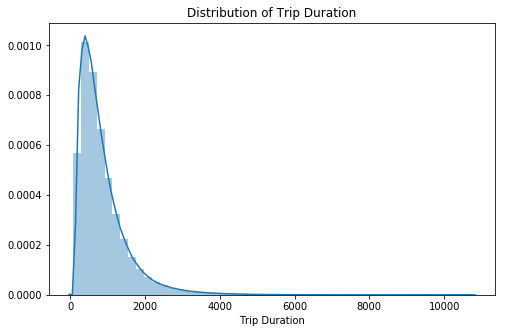

In [15]:
plt.figure(figsize=(8,5))
sns.distplot(df_train['trip_duration']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration")

reduces the impact of outliers

In [16]:
df_train['trip_duration'] = np.log(df_train['trip_duration'].values)

#### 3.2 Missing values handling

In [17]:
df_train[pd.isnull(df_train)].sum()

id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
distance              0.0
dtype: float64

No missing Values

#### 3.3 Gestion des variables catégoriques

convert pickup dateime and dropoff datetime into date-time object

In [18]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

In [19]:
df_train['hour'] = df_train.loc[:,'pickup_datetime'].dt.hour;
df_train['week'] = df_train.loc[:,'pickup_datetime'].dt.week;
df_train['weekday'] = df_train.loc[:,'pickup_datetime'].dt.weekday;
df_train['hour'] = df_train.loc[:,'pickup_datetime'].dt.hour;
df_train['month'] = df_train.loc[:,'pickup_datetime'].dt.month;

df_test['hour'] = df_test.loc[:,'pickup_datetime'].dt.hour;
df_test['week'] = df_test.loc[:,'pickup_datetime'].dt.week;
df_test['weekday'] = df_test.loc[:,'pickup_datetime'].dt.weekday;
df_test['hour'] = df_test.loc[:,'pickup_datetime'].dt.hour;
df_test['month'] = df_test.loc[:,'pickup_datetime'].dt.month;

# 4 Features engineering :

#### 4.1 Features selection

In [20]:
y_train = df_train["trip_duration"]
X_train = df_train[["vendor_id", "passenger_count", "pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude", "distance", "hour", "week", "weekday", "month" ]]


#### 4.2 Features extraction

#### 4.3 Features creation

# 5 Choix d'un méthode de validation

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.2, random_state=42)

In [22]:
%%time
from sklearn.ensemble import RandomForestRegressor
m = RandomForestRegressor(n_estimators=35,min_samples_leaf=100, min_samples_split=100, n_jobs=-1)
m.fit(X_train, y_train)

CPU times: user 6min 19s, sys: 456 ms, total: 6min 19s
Wall time: 3min 15s


# 6 Sélection de modèles et/ou datasets (si il y en a plusieurs)

# 7 Entrainement du ou des modèle(s)

Validation

In [23]:
X_test = df_test[["vendor_id", "passenger_count","pickup_longitude", "pickup_latitude","dropoff_longitude","dropoff_latitude","distance", "hour", "week", "weekday", "month"]]
prediction = m.predict(X_test)
prediction

array([6.5090018 , 6.35237708, 6.16264463, ..., 7.27331353, 7.38995481,
       7.02490021])

# 8 Prédictions

In [24]:
submit = pd.read_csv('../input/sample_submission.csv')
submit.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


In [25]:
my_submission = pd.DataFrame({'id': df_test.id, 'trip_duration': np.exp(prediction)})
my_submission.head()

,id,trip_duration
0,id3004672,671.156138
1,id3505355,573.855187
2,id1217141,474.681773
3,id2150126,1106.369517
4,id1598245,375.384305


In [26]:
my_submission.to_csv('submission.csv', index=False)